In [100]:
from skimage import data, io, filters, novice
from scipy import ndimage
from numpy.linalg import inv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

In [3]:
from matting import blue_screen_matting, bayes_matting, triangulation_matting

# Blue Screen Matting

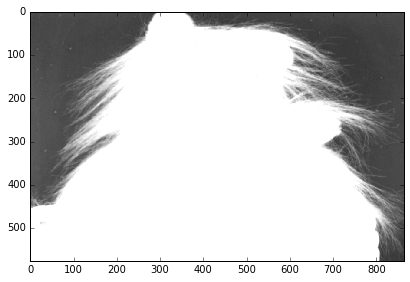

In [15]:
img = io.imread("input.jpg")
res = blue_screen_matting(1,1, img)
io.imshow(res)

# Triangulation Matting

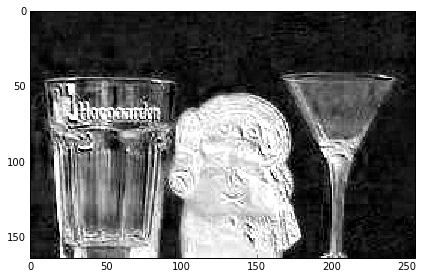

In [4]:
img1 = io.imread("triangulation/img1.jpg")
bg1 = io.imread("triangulation/bg1.jpg")

img2 = io.imread("triangulation/img2.jpg")
bg2 = io.imread("triangulation/bg2.jpg")

res = triangulation_matting(img1, bg1, img2, bg2)
io.imshow(res)

# Bayes Matting

In [8]:
img = io.imread("Bayes/donkey.png")
tri = io.imread("Bayes/donkey_tri.png")
f, b, alpha = bayes_matting(img, tri, sigma_d=2, it=2)
io.imshow(alpha)

# Vlahos

$\alpha(I_b, I_g) = 1 - a_1 (I_b - a_2 I_g)$ 

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def vlahos(Ib, Ig, a1, a2):
    """Evaluate Vlahos formula with given I_b and I_g"""
    return 1 - a1 * (Ib - a2 * Ig)

def evaluate_vlahos(a1=0.5, a2=1):   
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0, 1, 0.2)
    X, Y = np.meshgrid(x, y)
    zs = np.array([vlahos(x,y, a1, a2) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    ax.plot_surface(X, Y, Z)
    plt.show()

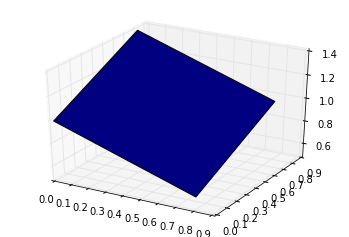

In [51]:
evaluate_vlahos(0.5, 1)

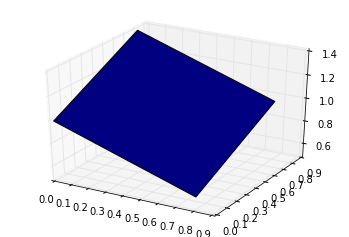

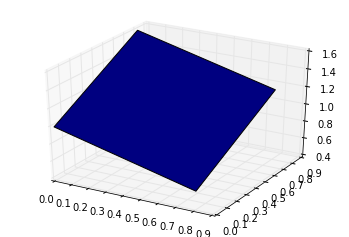

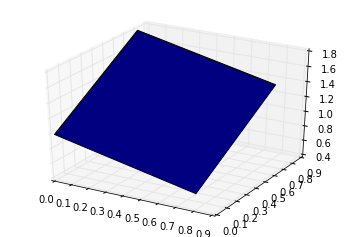

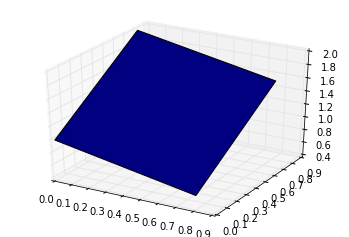

In [57]:
for i in np.arange(1, 3, 0.5):
    evaluate_vlahos(0.5, i)

# 2.7 Triangulation 

In [77]:
f1 = np.array([150, 100, 200])
blue = np.array([0, 2550, 0])
f2 = np.array([140, 180, 40])
green = np.array([0, 0, 255])

def triangulation(f1, b1, f2, b2):
    return 1 - np.dot(f1 - f2, b1 - b2) / float(np.dot(b1 - b2, b1 - b2))

triangulation(f1, blue, f2, green)

1.0372743156668609

# 2.9 Bayes Matting 


In [148]:
from numpy.linalg import LinAlgError

def bayes_calculate_FB(I, a, sigma_d, mean_F, cov_F, mean_B, cov_B):
    try:
        inv_cov_B = np.linalg.inv(cov_B)
        inv_cov_F = np.linalg.inv(cov_F)
    except LinAlgError:
        print("LinAlgError")
    
    a_11 = inv_cov_F + (a**2 / sigma_d**2) * np.identity(3)
    a_22 = inv_cov_B + ((1 - a)**2 / sigma_d**2) * np.identity(3)
    a_12 = a_21 = (a * (1 - a) / sigma_d**2) * np.identity(3)

    b_1 = np.dot(inv_cov_F, mean_F) + (a / sigma_d**2) * I
    b_2 = np.dot(inv_cov_B, mean_B) + ((1 - a) / sigma_d**2) * I

    l = np.empty([6,6])
    l[0] = np.append(a_11[0], a_12[0])
    l[1] = np.append(a_11[1], a_12[1])
    l[2] = np.append(a_11[2], a_12[2])
    l[3] = np.append(a_21[0], a_22[0])
    l[4] = np.append(a_21[1], a_22[1])
    l[5] = np.append(a_21[2], a_22[2])
    r = np.append(b_1, b_2)

    return np.split(np.linalg.solve(l, r), 2)

def bayes_calculate_alpha(I, F, B):
    return (np.dot((I - B), (F - B)) / np.dot(F - B, F - B))
    
    
def bayes_calculation(p, sigma_d, alpha=0.1, it=10):
    for i in range(1):
        F, B = bayes_calculate_FB(p, alpha, sigma_d, mean_F, cov_F, mean_B, cov_B)
        alpha = bayes_calculate_alpha(p, F, B)
    return F, B, alpha

In [149]:
mean_F = np.array([150, 150, 150])
cov_F = np.array([[20, 5, 5], [5, 30, 8], [5, 8, 25]])

mean_B = np.array([50, 50, 200])
cov_B = np.array([[5, 0, 0], [0, 5, 0], [0, 0, 15]])

p = np.array([120, 125, 170])

In [150]:
bayes_calculation(p, 2, alpha=0.5, it=5)

(array([ 170.94039948,  179.97646996,  152.27047069]),
 array([  54.53800012,   54.76750715,  194.06267547]),
 0.56239575176655077)

In [151]:
bayes_calculation(p, 10, alpha=0.5, it=5)

(array([ 152.3039547 ,  153.68892136,  150.73356944]),
 array([  50.46538328,   50.57174171,  199.61203966]),
 0.692655296228332)

# Closed Form Matting
## How to get F and B from alpha matte
If alpha matte and the image itself is known, the vlahos equation is still underconstrained.
We somehow have to incorporate more information in order to get F and G. Levin et. al suggested to use
that F and G vary smoothly. This constraint leads to a solvable system of equations.


In [155]:
e = 10e-7

def matting_laplacian(I):
    """
    Calculates the inner sum of the matting laplacian
    
    param I: Image window
    """
    W = I.size / 3 
    mean_k = I.mean(axis=(0, 1))
    cov_K = np.cov(I.reshape(-1, 3).T)
    
    # TODO np.nditer(I) could be more convenient and faster
    L = np.zeros(I.shape[:-1])
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            delta = 0 if i != j else 1

            
def matting_affinity(i, j):
    pass

# Color Line Assumption Visualization

In [5]:
img1 = io.imread("triangulation/img1.jpg")
bg1 = io.imread("triangulation/bg1.jpg")

img2 = io.imread("triangulation/img2.jpg")
bg2 = io.imread("triangulation/bg2.jpg")

res = triangulation_matting(img1, bg1, img2, bg2)

In [154]:
# create subwindows
I = img1[10:19, 20:29]
B = bg1[10:19, 20:29]
alpha = res[10:19, 20:29]

In [156]:
def visualize_cla(I, B, alpha):
    """
    param I: window with image pixels
    param B: window with background pixels
    param alpha: window with alpha values
    """
    F = np.zeros(B.shape)
    nrows, ncols = B.shape[:-1]
    for row in range(nrows):
        for col in range(ncols):
            if alpha[row, col] != 0:
                F[row, col] = (I[row, col] - (1 - alpha[row, col]) * B[row, col]) / float(alpha[row, col])
            else:
                F[row, col] = [255, 255, 255]
    
    F = np.clip(F, 0, 255)

    _plot(I, "Image pixels")
    _plot(B, "Background pixels")
    _plot(F, "Foreground pixels")
    
    
    
def _plot(window, title):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('Red')
        ax.set_ylabel('Blue')
        ax.set_zlabel('Green')
        ax.set_title(title)
        
        t = window.reshape(-1, 3)
        X, Y, Z = t[:,0], t[:,1], t[:,2]
        ax.scatter3D(X, Y, Z)
        
        plt.show()
    
    

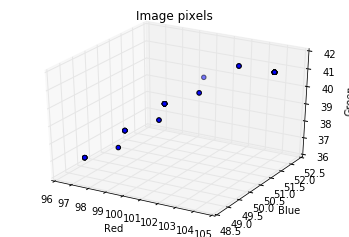

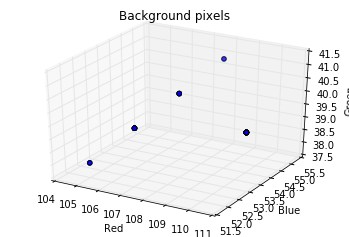

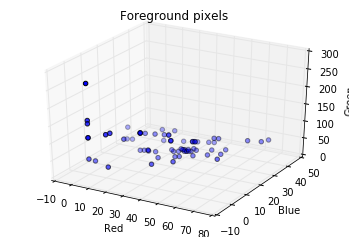

In [153]:
visualize_cla(I, B, alpha)